In [4]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout, GRU, Reshape
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [5]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16411202824774044366
 xla_global_id: -1]

In [2]:
X_train = np.load('training_data\specs_train_processed.npy')
print(f"before: {X_train.shape}")
X_train = np.swapaxes(X_train,2,1)
print(f"after: {X_train.shape}")
X_train = np.expand_dims(X_train,3)
print(f"final: {X_train.shape}")
y_train = np.load('training_data\labels_train_processed.npy')

before: (7983, 100, 130)
after: (7983, 130, 100)
final: (7983, 130, 100, 1)


In [3]:
X_train.shape[1:]

(130, 100, 1)

In [37]:
from keras import Model
from keras.layers import Input, Dense, concatenate
N_CLASSES = 10
a_input = Input(shape = X_train.shape[1:])
#1
a = Conv2D(filters=16, kernel_size=(3,3), input_shape=X_train.shape[1:])(a_input)
a = MaxPool2D(pool_size=(2,2))(a)
a = BatchNormalization()(a)
#2
a = Conv2D(filters=32, kernel_size=(3,3))(a)
a = (MaxPool2D(pool_size=(2,2)))(a)
a = (BatchNormalization())(a)
#3
a=(Conv2D(filters=64, kernel_size=(3,3)))(a)
a=(MaxPool2D(pool_size=(2,2)))(a)
a=(BatchNormalization())(a)
#4
a=(Conv2D(filters=128, kernel_size=(3,3)))(a)
a=(MaxPool2D(pool_size=(1,5)))(a)
a=(BatchNormalization())(a)
#5
a=(Conv2D(filters=128, kernel_size=(3,3)))(a)
a=(MaxPool2D(pool_size=(1,5)))(a)
a=(BatchNormalization())(a)
a = (Reshape((12,128)))(a)
# Recurrent Layer
a= (GRU(256, activation="tanh"))(a)
a = Model(inputs=a_input, outputs=a)


(None, 12, 1, 128)


In [38]:
from keras.layers import Embedding, Bidirectional
print(a_input.shape)
b = (MaxPool2D(pool_size=(1,2),strides = (3,2)))(a_input)
b = (Reshape((44,50)))(b)
b = Bidirectional(GRU(256))(b)
b = Model(inputs=a_input, outputs=b)

(None, 130, 100, 1)


In [39]:
mixed = concatenate([a.output,b.output])
z = Dense(64)(mixed)
z = Dropout(0.4)(z)
z = Dense(N_CLASSES,activation='softmax')(z)
# Output Layer

In [41]:
model = Model(inputs=a.input, outputs=z)


In [ ]:
# N_CLASSES = 10
# model = Sequential(name="gtzan_crnn")

# # Convolutional Block 1
# model.add(Conv2D(filters=16, kernel_size=(3,3), input_shape=X_train.shape[1:])) # X_train holds the processed training spectrograms
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(BatchNormalization())

# # Convolutional Block 2
# model.add(Conv2D(filters=32, kernel_size=(3,3)))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(BatchNormalization())

# # Convolutional Block 3
# model.add(Conv2D(filters=64, kernel_size=(3,3)))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(BatchNormalization())

# # Convolutional Block 4
# model.add(Conv2D(filters=128, kernel_size=(3,3)))
# model.add(MaxPool2D(pool_size=(1,5)))
# model.add(BatchNormalization())

# # Reshape Layer (effectively squeezes the frequency dimension away)
# model.add(Reshape((12,128)))
# # Recurrent Layer
# model.add(GRU(256, return_sequences=False, activation="tanh"))

# # Dense Layer
# model.add(Dense(64))
# model.add(Dropout(0.4))

# # Output Layer
# model.add(Dense(N_CLASSES, activation="softmax"))

In [42]:
x_valid = np.load('training_data\specs_val_processed.npy')
x_valid = np.swapaxes(x_valid,2,1)
x_valid = np.expand_dims(x_valid,3)
y_valid = np.load('training_data\labels_val_processed.npy')

In [43]:
features = pd.read_csv("features_final.csv")
features_valid = pd.read_csv("features_valid.csv")
features_test = pd.read_csv("features_test.csv")
features = features.drop('Unnamed: 0',axis=1)
features_test = features_test.drop('Unnamed: 0',axis=1)
features_valid = features_valid.drop('Unnamed: 0',axis=1)

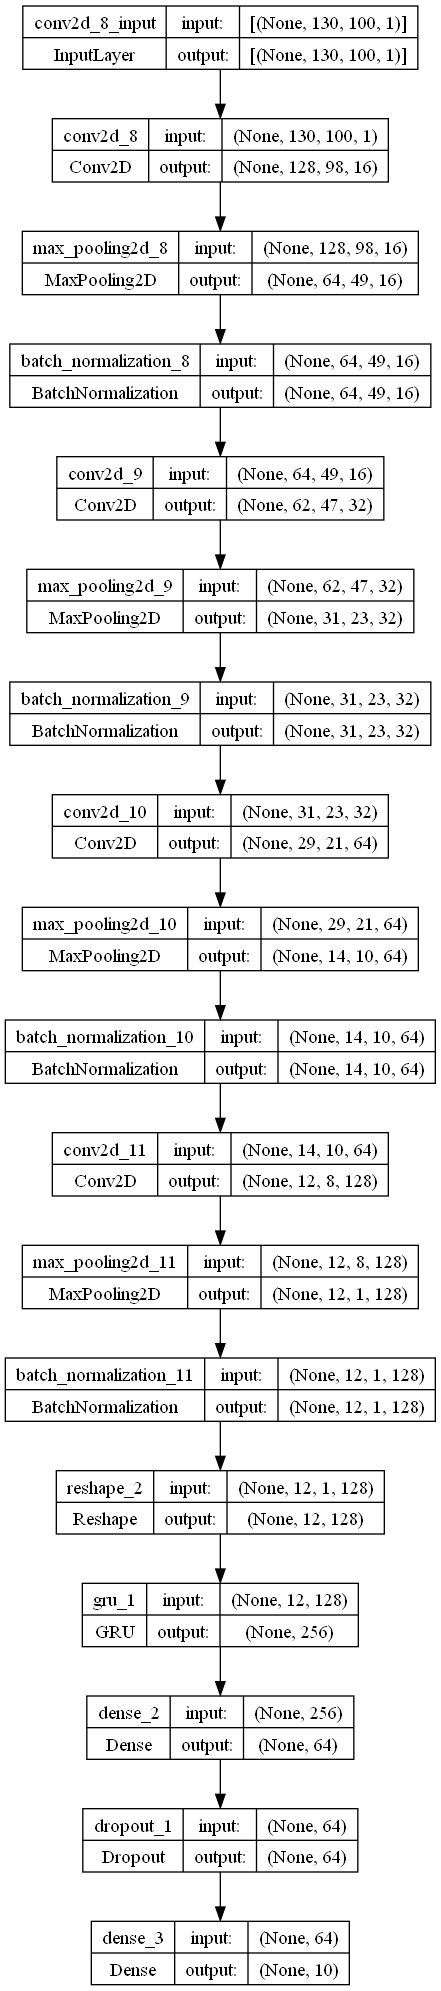

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [46]:
model.compile(optimizer = keras.optimizers.RMSprop(learning_rate=0.0001,rho=0.9),
              loss = keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.fit(x= X_train, y=y_train, epochs = 25, validation_data = (x_valid, y_valid), batch_size=64)

Epoch 1/25
125/125 [==============================] - 114s 746ms/step - loss: 1.8218 - accuracy: 0.3398 - val_loss: 2.4504 - val_accuracy: 0.1204
Epoch 2/25
125/125 [==============================] - 90s 719ms/step - loss: 1.5292 - accuracy: 0.4568 - val_loss: 2.3808 - val_accuracy: 0.1528
Epoch 3/25
125/125 [==============================] - 106s 853ms/step - loss: 1.3744 - accuracy: 0.5202 - val_loss: 2.2968 - val_accuracy: 0.2885
Epoch 4/25
125/125 [==============================] - 112s 893ms/step - loss: 1.2429 - accuracy: 0.5791 - val_loss: 2.0057 - val_accuracy: 0.3684
Epoch 5/25
125/125 [==============================] - 111s 889ms/step - loss: 1.1299 - accuracy: 0.6156 - val_loss: 1.7009 - val_accuracy: 0.4453
Epoch 6/25
125/125 [==============================] - 106s 844ms/step - loss: 1.0340 - accuracy: 0.6467 - val_loss: 1.3634 - val_accuracy: 0.5466
Epoch 7/25
125/125 [==============================] - 118s 945ms/step - loss: 0.9558 - accuracy: 0.6827 - val_loss: 1.5333 - 

In [47]:
x_test = np.load('training_data\specs_test_processed.npy')
x_test = np.swapaxes(x_test,2,1)
x_test = np.expand_dims(x_test,3)
y_test = np.load('training_data\labels_test_processed.npy')

In [48]:
model.evaluate(x=x_test, y=y_test)

32/32 [==============================] - 3s 102ms/step - loss: 2.1157 - accuracy: 0.5396


[2.115651845932007, 0.5396039485931396]

## Confusion Matrix

In [50]:
genres = {
 0:'blues',
 1:'classical',
 2:'country',
 3:'disco',
 4:'hiphop',
 5:'jazz',
 6:'metal',
 7:'pop',
 8:'reggae',
 9:'rock'
}

32/32 [==============================] - 3s 95ms/step


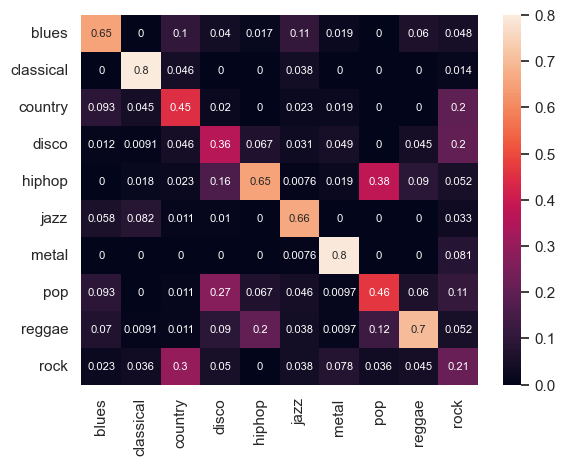

In [51]:

y_prediction = model.predict(x_test)
y_prediction = np.argmax (y_prediction, axis = 1)
result = confusion_matrix(y_test, y_prediction , normalize='pred')

df_cm = pd.DataFrame(result, (genres.values()), (genres.values()))
#plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}) # font size

plt.show()

In [ ]:
data.shape

NameError: name 'data' is not defined